In [1]:
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics as m
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sns


Read the data
===========

In [2]:
x_original=pd.read_csv('../_xlable4_withNa_AllColumns.txt')
y_original=pd.read_csv('../_targelable4_withNa_AllColumns.txt')


x_original['max']=np.min(x_original[['FIELD_6','FIELD_7']],axis=1)
x_original=x_original.drop(columns=['FIELD_6','FIELD_7'])
x_original=x_original.query('FIELD_16 != 1 and FIELD_23 != 1')

y_original['max']=np.min(y_original[['FIELD_6','FIELD_7']],axis=1)
y_original=y_original.drop(columns=['FIELD_6','FIELD_7'])
y_original=y_original.query('FIELD_16 != 1 and FIELD_23 != 1')



In [3]:

x=x_original[['Unnamed: 0','S000502', 'S000501', 'S000300', 'L100700', 'S010102',
       'L100800', 'L101700', 'S000100', 'L103000', 'L190400', 'L103100',
       'L190300', 'L101300', 'FIELD_42',
              
             'FIELD_15','FIELD_17','FIELD_22','FIELD_24','FIELD_16','FIELD_23','AGE','SEX']]

y=y_original[['Unnamed: 0','S000502']]

print(x_original.shape)
print(y_original.shape)

(159381, 407)
(159381, 407)


Prepare the data
============

In [4]:
data= pd.merge(x,y, how='inner',left_on='Unnamed: 0', right_on='Unnamed: 0')
data=data.query('FIELD_15 !=1 and FIELD_17 !=1 and FIELD_22 != 1 and FIELD_24 != 1 and FIELD_16 != 1 and FIELD_23 != 1')

# data=data[data.SEX==0]
# data=data[data.AGE>=40]
data=data.dropna(). reset_index()

# data=data[data.FIELD_15!=1]
# data=data[data.FIELD_17!=1]
# data=data[data.FIELD_22!=1]
# data=data[data.FIELD_24!=1]

# data['max']=np.min(data[['FIELD_6','FIELD_7']],axis=1)
# data=data.drop(columns=['FIELD_6','FIELD_7'])
# data=data.query('FIELD_16 != 1 and FIELD_23 != 1')


print(data.shape)
data.head()

(129281, 25)


,index,Unnamed: 0,S000502_x,S000501,S000300,L100700,S010102,L100800,L101700,S000100,...,FIELD_42,FIELD_15,FIELD_17,FIELD_22,FIELD_24,FIELD_16,FIELD_23,AGE,SEX,S000502_y
0,0,0,67.0,121.0,20.1,3.0,15.0,77.0,13.0,159.8,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,1.0,76.0
1,1,1,76.0,117.0,19.7,3.0,14.0,89.0,14.0,159.5,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,1.0,82.0
2,2,2,82.0,135.0,20.2,3.8,14.0,78.0,15.0,159.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,1.0,78.0
3,3,3,71.0,118.0,24.8,3.7,11.0,95.0,10.0,155.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,1.0,65.0
4,4,4,65.0,111.0,25.5,3.4,14.0,90.0,12.0,156.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,1.0,65.0


Check the correlation of the selected feature with the independent variables
=====

In [6]:
temppd=pd.DataFrame(data.copy()[['S000502_x', 'S000501', 'SEX', 'S000300', 'AGE', 'L100700', 'S010102',
       'L100800', 'L101700', 'S000100', 'L103000', 'L190400', 'L103100',
       'L190300', 'L101300', 'FIELD_42'
                                ]]).dropna() 
temppd['y']=data.S000502_y
temppd.corr().y.head(20)
# corval=abs(temppd.corr()).sort_values(by='y', ascending=False)

# corr = (temppd.corr())
# sns.heatmap(corr, vmin=-1, vmax=1)

# # mask = np.zeros_like(corr)
# # mask[np.triu_indices_from(mask)] = True
# # with sns.axes_style("white"):
# #     ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)

# corr.head(20)

S000502_x    0.584668
S000501      0.575086
SEX         -0.325820
S000300      0.362089
AGE          0.157318
L100700      0.305070
S010102      0.166165
L100800      0.237270
L101700      0.235501
S000100      0.209591
L103000      0.252539
L190400      0.322489
L103100     -0.189594
L190300      0.316356
L101300      0.210209
FIELD_42     0.011967
y            1.000000
Name: y, dtype: float64

In [30]:
y=data[['S000502_y']]

x=data[['S000502_x', 'S000501', 'SEX', 'S000300',
        'AGE', 'L100700', 'S010102','L100800', 
        'L101700', 'S000100', 'L103000', 
        'L190400', 'L103100',
       'L190300', 'L101300', 'FIELD_42']]
print(x.columns)

Index(['S000502_x', 'S000501', 'SEX', 'S000300', 'AGE', 'L100700', 'S010102',
       'L100800', 'L101700', 'S000100', 'L103000', 'L190400', 'L103100',
       'L190300', 'L101300', 'FIELD_42'],
      dtype='object')


Apply PCA
===========

In [31]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=8)
# pca.fit(x)

# print(pca.explained_variance_ratio_)   
# print(np.sum(pca.explained_variance_ratio_))

# x=pca.fit_transform(x) 
# print(x.shape)


feature scaling
=======

In [32]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()  #StandardScaler()
# x = min_max_scaler.fit_transform(x)

clustring test
==========

In [33]:
# from sklearn.cluster import KMeans
# from scipy.spatial.distance import cdist

# K = range(1,10)
# distortions = []

# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(x)
#     kmeanModel.fit(x)
#     distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()


In [34]:
# kmeanModel = KMeans(n_clusters=k).fit(x)
# x['lbl']=kmeanModel.labels_ 

Random Forest Regressor
=============

In [35]:
ylable=y[['S000502_y']]  
xtrain,xtest,ytrain,ytest=train_test_split(x, ylable, random_state=42, test_size=0.2)

In [36]:
regr = RandomForestRegressor(max_depth=7, random_state=0,verbose =0,n_estimators=50)
regr.fit(xtrain, ytrain) 
print(regr.feature_importances_)
ypred=regr.predict(xtest)


[6.52900426e-01 2.53721400e-01 2.42397646e-02 2.40247304e-02
 9.19163406e-03 3.19670539e-03 4.14416995e-04 1.17446303e-03
 1.81366837e-02 7.46675547e-04 2.47013550e-03 4.16539111e-03
 1.08725332e-03 3.31347406e-03 1.02227659e-03 1.94569502e-04]


mean_squared_error 49.538759218074084
root mean_squared_error 7.0383775984294905
mean_absolute_error 5.67769782130773
r2_score 0.4119509414123994


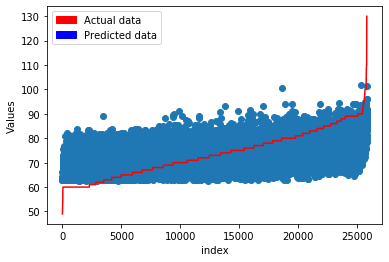

,t + 1,pred (t +1)
25371,112.0,83.102008
8257,113.0,83.795418
11560,114.0,81.484854
521,114.0,91.349131
15360,115.0,90.544068
17743,115.0,91.342187
14972,119.0,87.459681
17579,120.0,95.948877
2019,122.0,101.506766
23390,130.0,85.599899


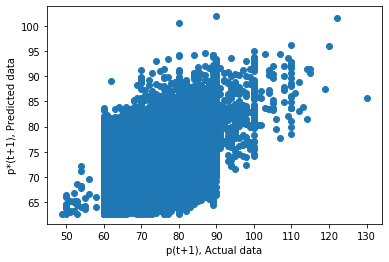

In [37]:
import math
print('mean_squared_error',m.mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(m.mean_squared_error(ytest, ypred)))
print('mean_absolute_error',m.mean_absolute_error(ytest, ypred))
print('r2_score',m.r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.tail(10)

xg boost
==========

In [38]:
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, 
#                           learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',max_depth = 10, alpha = 200, n_estimators = 50, 
                          booster='gbtree',
                          colsample_bytree = 0.6,learning_rate = 0.08,gamma=10, tree_method = 'gpu_hist'
                         )

xg_reg.fit(xtrain, ytrain) 

XGBRegressor(alpha=200, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=10,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

In [39]:

ypred = xg_reg.predict(xtest)
 
print('mean_squared_error',m.mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(m.mean_squared_error(ytest, ypred)))
print('mean_absolute_error',m.mean_absolute_error(ytest, ypred))
print('r2_score',m.r2_score(ytest, ypred))


mean_squared_error 50.3143474826771
root mean_squared_error 7.093260708776825
mean_absolute_error 5.6745545558071555
r2_score 0.4027443331716949


ANN
==========

In [ ]:
model= Sequential()
model.add(Dense(input_dim=32,units=128,activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=128, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=32, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=16, activation='relu', kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=8, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=1, kernel_initializer='uniform'))
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mean_squared_error' ])

In [ ]:
h=model.fit(xtrain, ytrain, validation_split=.2,epochs=100, batch_size=50)

In [ ]:
ypred=model.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)

In [ ]:
history=h
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
ypredPD['diff']=abs(ypredPD['t + 1']- ypredPD['pred (t +1)'])
print(np.mean(ypredPD['diff']))
print(np.std(ypredPD['diff']))
print(100*ypredPD[ypredPD['diff']<=5].shape[0]/ypredPD.shape[0])

In [ ]:

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.head(10)

SVR
======

In [ ]:
from sklearn.svm import SVR
# svr_rbf = SVR(kernel='rbf', C=10, gamma=0.02, epsilon=.001)
svr_rbf = SVR(kernel='rbf')

In [ ]:
svr_rbf.fit(xtrain, ytrain) 

In [ ]:
ypred=svr_rbf.predict(xtest)

In [ ]:
import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)